# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Цель задачи
Целью проекта является разработка модели машинного обучения, способной предсказывать рыночную стоимость автомобилей на основе различных технических характеристик и комплектации. Модель должна обеспечивать высокое качество предсказания, а также минимальное время обучения и предсказания.

# План работы
1. **Подготовка данных**:

    * **Загрузка данных**
    
       - Загрузить данные из файла `/datasets/autos.csv`.

    * **Изучение данных**

    * **Обработка данных**
    
    
2. **Обучение моделей**

    * **Подготовка выборок**
        - Разделить данные на обучающую и тестовую выборки.
        - Определить целевой признак (цена) и признаки для обучения.
    * **Обучение моделей**
        - Обучить несколько моделей, включая:
        - LightGBM (градиентный бустинг).
        - Одну не бустинговую модель, например, линейную регрессию.
        - Экспериментировать с гиперпараметрами для каждой модели.


3. **Анализ моделей**

      - Проанализировать время обучения и предсказания для каждой модели.
      - Рассчитать метрику RMSE для оценки качества предсказаний.
      - Убедиться, что значение RMSE меньше 2500.
      

4. **Выбор лучшей модели**

   - На основе анализа выбрать модель, которая лучше всего соответствует критериям заказчика.
   - Проверить качество выбранной модели на тестовой выборке.


# Описание данных  
  
# Признаки  
  
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя 

# Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
!pip -q install -q phik
!pip install -q shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap

from phik import phik_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import time

In [3]:
RANDOM_STATE = 42

In [4]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [5]:
def analyze(df, name):
    """
    Функция для анализа датафрейма
    :param df: датафрейм для анализа
    :param name: имя датафрейма
    """
    print(f"\nАнализ DataFrame: {name}\n")
    
    # 1. Общая информация о DataFrame
    print("Общая информация:")
    display(df.head())
    display(df.info())

    # 2. Описательная статистика
    print("Описательная статистика:")
    display(df.describe(include='all'))

    # 3. Анализ по каждому столбцу
    for col in df.columns:
        print('-' * 30)
        print(f"Анализ столбца: {col}")

        # 3.1 Тип данных и количество уникальных значений
        dtype = df[col].dtype
        num_unique = df[col].nunique()
        print(f"Тип данных: {dtype}, Количество уникальных значений: {num_unique}")

        # 3.2 Уникальные значения (отсортированные) - вывод только если мало уникальных значений
        if num_unique <= 20:
            unique_values = df[col].sort_values().unique()
            print(f"Уникальные значения: {unique_values}")
        elif num_unique <= 50:  # Вывод первых и последних 10 значений, если их не слишком много
            unique_values = df[col].sort_values().unique()
            print(f"Первые 10 уникальных значений: {unique_values[:10]}")
            print(f"Последние 10 уникальных значений: {unique_values[-10:]}")

        # 3.3 Количество и процент пропущенных значений (NaN, None)
        num_missing = df[col].isnull().sum()
        percent_missing = round(df[col].isnull().mean() * 100, 2)
        print(f"Количество пропущенных значений (NaN, None): {num_missing}, Процент: {percent_missing}%")

        # 3.4 Количество и процент нулевых значений - только для числовых
        if pd.api.types.is_numeric_dtype(dtype):
            num_zeros = (df[col] == 0).sum()
            percent_zeros = round(num_zeros / len(df) * 100, 2)
            print(f"Количество 0: {num_zeros}, Процент 0: {percent_zeros}%")

        # 3.5 Проверка пропусков для текстовых столбцов (пустые строки и пробелы)
        if pd.api.types.is_string_dtype(dtype):
            num_empty = (df[col] == "").sum() + (df[col] == " ").sum()
            percent_empty = round(num_empty / len(df) * 100, 2)
            print(f"Количество пустых строк и пробелов: {num_empty}, Процент: {percent_empty}%")

        print('-' * 30, "\n")

    # 4. Проверка полных дублей
    num_duplicates = df.duplicated().sum()
    percent_duplicates = round(num_duplicates / len(df) * 100, 2)
    print(f"Количество полных дублей: {num_duplicates}, Процент полных дублей: {percent_duplicates}%")


In [6]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [7]:

# Функция для построения гистограмм и ящиков с усами
def plot_numerical_features(df, features):
    for feature in features:
        plt.figure(figsize=(12, 5))
        
        # Гистограмма
        plt.subplot(1, 2, 1)
        sns.histplot(df[feature], bins=30, kde=True, color='skyblue')
        plt.title(f'Гистограмма: {feature}')
        plt.xlabel(feature)
        plt.ylabel('Частота')
        
        # Вычисление среднего и медианы
        mean_value = df[feature].mean()
        median_value = df[feature].median()
        
        # Отображение среднего и медианы на гистограмме
        plt.axvline(mean_value, color='red', linestyle='--', label=f'Среднее: {mean_value:.2f}')
        plt.axvline(median_value, color='orange', linestyle='-', label=f'Медиана: {median_value:.2f}')
        
        # Легенда для гистограммы
        plt.legend()
        
        # Ящик с усами
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[feature], color='lightgreen')
        plt.title(f'Ящик с усами: {feature}')
        
        # Отображение среднего и медианы на ящике с усами
        plt.axvline(mean_value, color='red', linestyle='--', label=f'Среднее: {mean_value:.2f}')
        plt.axvline(median_value, color='orange', linestyle='-', label=f'Медиана: {median_value:.2f}')
        
        # Легенда для ящика с усами
        plt.legend()
        
        plt.tight_layout()
        plt.show()

In [8]:
# Функция для построения графиков для категориальных признаков с учетом частоты
def plot_categorical_features_with_frequency(df, feature, top_n=10):
    # Считаем количество уникальных значений
    value_counts = df[feature].value_counts()
    
    # Отбираем только топ-N значений
    top_values = value_counts.nlargest(top_n)
    
    # Объединяем менее частые значения в категорию "Другие"
    other_count = value_counts[top_n:].sum()
    if other_count > 0:
        top_values = top_values.append(pd.Series({'Другие': other_count}))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_values.index, y=top_values.values, palette='viridis')
    plt.title(f'Наиболее частые значения для {feature}')
    plt.xlabel(feature)
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.show()


In [9]:
# Функция для построения графиков по временным меткам
def plot_time_series(df, date_column, title):
    plt.figure(figsize=(12, 6))
    df[date_column].dt.to_period('M').value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel('Дата')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)
    plt.show()


In [10]:
# Функция для построения графиков для категориальных признаков
def plot_categorical_features(df, features):
    for feature in features:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=feature, order=df[feature].value_counts().index, palette='viridis')
        plt.title(f'Распределение по признаку: {feature}')
        plt.xlabel(feature)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        plt.show()


In [11]:
def report_removed_data(data):
    """
    Функция для отчета о количестве удаленных записей в DataFrame.
    
    :param initial_count: Исходное количество записей
    :param cleaned_data: Очищенный DataFrame
    """
    # Исходное количество записей
    initial_count = 354369 

    # Количество записей после удаления
    cleaned_count = len(data)

    # Количество удаленных записей
    removed_count = initial_count - cleaned_count

    # Доля удаленных данных
    removed_percentage = (removed_count / initial_count) * 100

    # Вывод результатов
    print(f"Исходное количество записей: {initial_count}")
    print(f"Количество записей после удаления: {cleaned_count}")
    print(f"Количество удаленных записей: {removed_count}")
    print(f"Доля удаленных данных: {removed_percentage:.2f}%")

In [12]:
analyze(data, 'autos.csv')


Анализ DataFrame: autos.csv

Общая информация:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

Описательная статистика:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


------------------------------
Анализ столбца: DateCrawled
Тип данных: object, Количество уникальных значений: 271174
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: Price
Тип данных: int64, Количество уникальных значений: 3731
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 10772, Процент 0: 3.04%
------------------------------ 

------------------------------
Анализ столбца: VehicleType
Тип данных: object, Количество уникальных значений: 8
Уникальные значения: ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan]
Количество пропущенных значений (NaN, None): 37490, Процент: 10.58%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: RegistrationYear
Тип данных: int64, Количество уникальных значений: 151
Количество пр

In [13]:
#пропуски
missing_data(data)

,Total,Percent
Repaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588
DateCrawled,0,0.000000
Price,0,0.000000
RegistrationYear,0,0.000000
Power,0,0.000000
Kilometer,0,0.000000


**1. Общая информация**
- В датасете 354,369 записей и 16 столбцов.
- В данных есть пропуски в столбцах: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired`.
- В столбцах `NumberOfPictures` и `RegistrationMonth` есть нулевые значения.

**2. Анализ признаков**

**Целевой признак (`Price`):**
- Данные не содержат отрицательных значений.
- Есть нулевые значения (10,772, 3.04%), требующие проверки.

**Дата и время (`DateCrawled`, `DateCreated`, `LastSeen`):**
- Эти столбцы содержат информацию о датах и времени.
- Приведём столбцы с датой к формату datetime64 для анализа временных зависимостей.

**Тип автомобиля (`VehicleType`):**
- 8 уникальных значений, включая NaN.
- Требуется обработать пропущенные значения.

**Год и месяц регистрации (`RegistrationYear`, `RegistrationMonth`):**
- В `RegistrationYear` есть аномальные значения (например, 1000).
- Необходимо удалить выбросы.
- В `RegistrationMonth` есть 0, которые могут быть ошибкой ввода.

**Коробка передач (`Gearbox`):**
- 2 уникальных значения: `auto` и `manual`, а также NaN.
- Требуется обработать пропущенные значения.

**Мощность (`Power`):**
- Есть 0 значения (11.35%), требующие проверки.
- Возможно, потребуется нормализация.

**Модель автомобиля (`Model`):**
- 250 уникальных значений, включая NaN.
- Требуется обработать пропущенные значения.

**Пробег (`Kilometer`):**
- 13 уникальных значений.
- Возможно, потребуется преобразование в категориальный признак.

**Тип топлива (`FuelType`):**
- 7 уникальных значений, включая NaN.
- Требуется обработать пропущенные значения.

**Марка автомобиля (`Brand`):**
- 40 уникальных значений.
- Возможно, потребуется кодирование.

**Ремонт (`Repaired`):**
- 2 уникальных значения: `yes` и `no`, а также NaN.
- Требуется обработать пропущенные значения.

**Количество фотографий (`NumberOfPictures`):**
- Все значения - 0.
- Этот столбец не информативен, его можно удалить.

**Почтовый индекс (`PostalCode`):**
- 8143 уникальных значений.
- Возможно, потребуется кодирование или использовать только часть информации (например, первые две цифры почтового индекса).


In [14]:
fill_values = {
    'Repaired': 'no',
    'FuelType': 'other',
    'Gearbox': 'manual',
    'VehicleType': 'unk',  
    'Model': 'unk'         
}

# Заполнение пропусков в категориальных переменных
for column, value in fill_values.items():
    data[column] = data[column].fillna(value)

# Удалим 'NumberOfPictures', так как он не информативен
data = data.drop(['NumberOfPictures'], axis=1)

# Проверка на наличие пропусков после заполнения
missing_data(data)

,Total,Percent
DateCrawled,0,0.0
Price,0,0.0
VehicleType,0,0.0
RegistrationYear,0,0.0
Gearbox,0,0.0
Power,0,0.0
Model,0,0.0
Kilometer,0,0.0
RegistrationMonth,0,0.0
FuelType,0,0.0


In [15]:
print(f"Количество дубликатов до обработки: {data.duplicated().sum()}")

Количество дубликатов до обработки: 5


In [16]:
# Удалим дубликаты
data = data.drop_duplicates()

In [17]:
# Проверим количество дубликатов после обработки
data = data.drop_duplicates()
print(f"Количество дубликатов после обработки: {data.duplicated().sum()}")

Количество дубликатов после обработки: 0


In [18]:
report_removed_data(data)

Исходное количество записей: 354369
Количество записей после удаления: 354364
Количество удаленных записей: 5
Доля удаленных данных: 0.00%


In [19]:
analyze(data, 'autos.csv')


Анализ DataFrame: autos.csv

Общая информация:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,unk,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
Int64Index: 354364 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354364 non-null  object
 1   Price              354364 non-null  int64 
 2   VehicleType        354364 non-null  object
 3   RegistrationYear   354364 non-null  int64 
 4   Gearbox            354364 non-null  object
 5   Power              354364 non-null  int64 
 6   Model              354364 non-null  object
 7   Kilometer          354364 non-null  int64 
 8   RegistrationMonth  354364 non-null  int64 
 9   FuelType           354364 non-null  object
 10  Brand              354364 non-null  object
 11  Repaired           354364 non-null  object
 12  DateCreated        354364 non-null  object
 13  PostalCode         354364 non-null  int64 
 14  LastSeen           354364 non-null  object
dtypes: int64(6), object(9)
memory usage: 43.3+ MB


None

Описательная статистика:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
count,354364,354364.000000,354364,354364.000000,354364,354364.000000,354364,354364.000000,354364.000000,354364,354364,354364,354364,354364.000000,354364
unique,271174,NaN,9,NaN,2,NaN,251,NaN,NaN,7,40,2,109,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,2016-04-06 13:45:54
freq,7,NaN,91456,NaN,288081,NaN,29232,NaN,NaN,216349,77012,318311,13718,NaN,17
mean,NaN,4416.655608,NaN,2004.234471,NaN,110.093723,NaN,128211.373051,5.714641,NaN,NaN,NaN,NaN,50508.461698,NaN
std,NaN,4514.159690,NaN,90.228593,NaN,189.851590,NaN,37905.136957,3.726433,NaN,NaN,NaN,NaN,25783.124276,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,49409.500000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,71083.000000,NaN


------------------------------
Анализ столбца: DateCrawled
Тип данных: object, Количество уникальных значений: 271174
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: Price
Тип данных: int64, Количество уникальных значений: 3731
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 10772, Процент 0: 3.04%
------------------------------ 

------------------------------
Анализ столбца: VehicleType
Тип данных: object, Количество уникальных значений: 9
Уникальные значения: ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'unk' 'wagon']
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: RegistrationYear
Тип данных: int64, Количество уникальных значений: 151
Количество пропущ

**Проверим количественные столбцы на наличие аномалий**

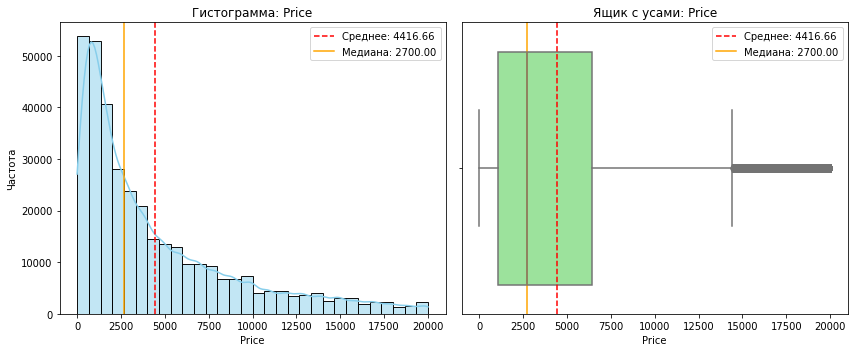

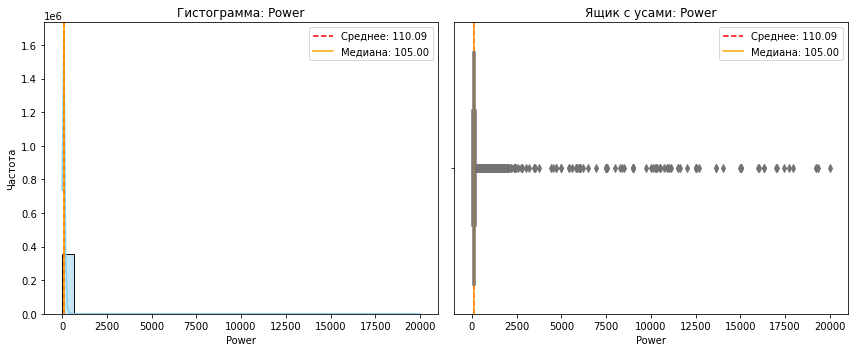

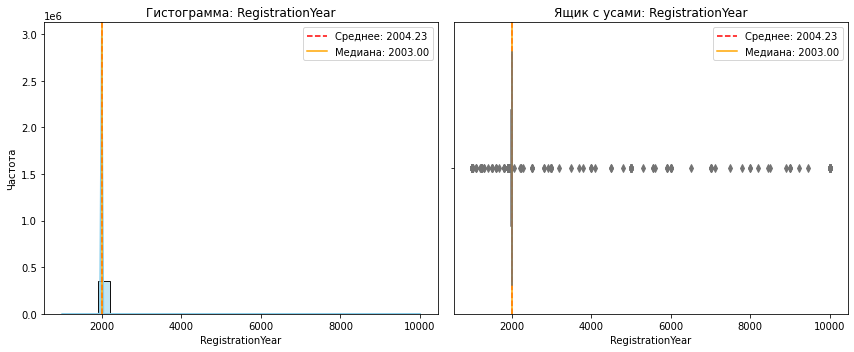

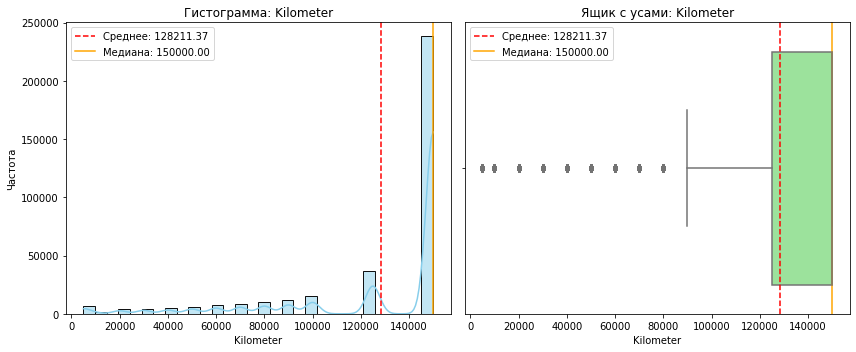

In [20]:
# Список количественных признаков для анализа
numerical_features = ['Price', 'Power', 'RegistrationYear', 'Kilometer']

# Визуализация
plot_numerical_features(data, numerical_features)


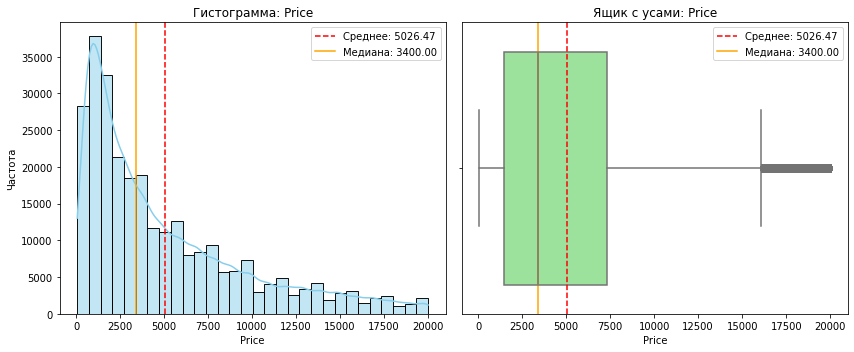

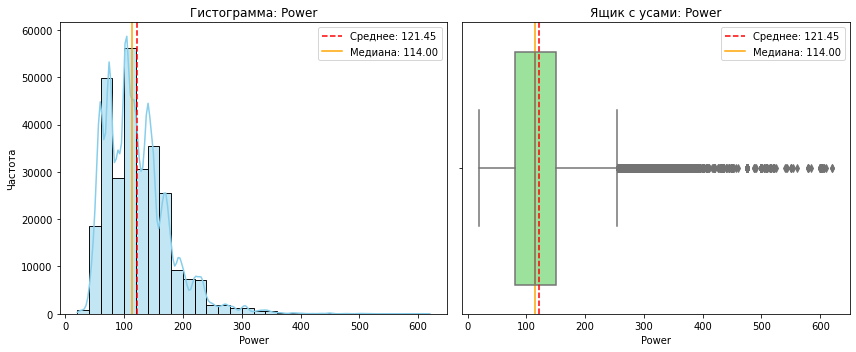

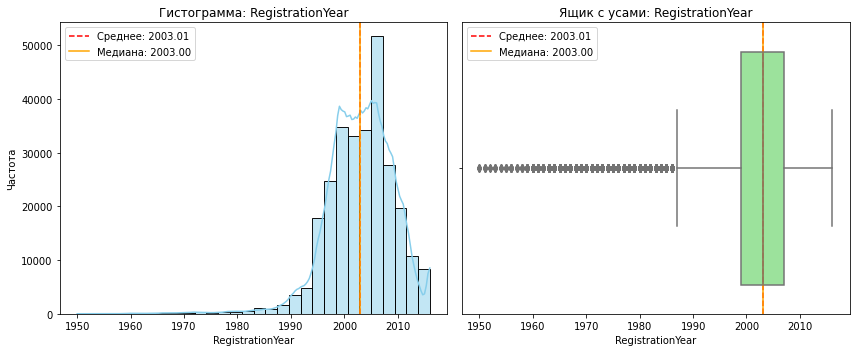

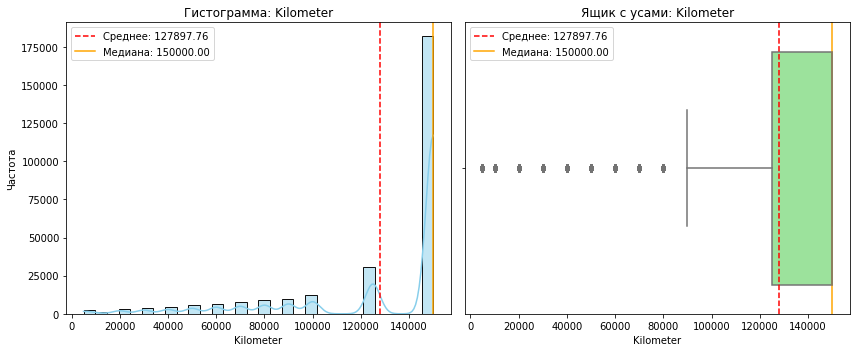

In [21]:
# Фильтрация записей с ценой ниже 20€
data = data[data['Price'] >= 70]

# Фильтрация данных по Power
data = data[(data['Power'] >= 20) & (data['Power'] <= 620)]

# Фильтрация данных по RegistrationYear
data = data[(data['RegistrationYear'] >= 1950) & (data['RegistrationYear'] <= 2016)]

# Фильтрация данных по RegistrationMonth
data = data[(data['RegistrationMonth'] > 0)]

plot_numerical_features(data, numerical_features)

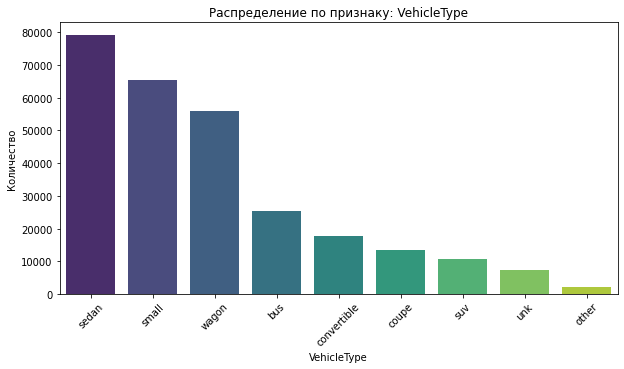

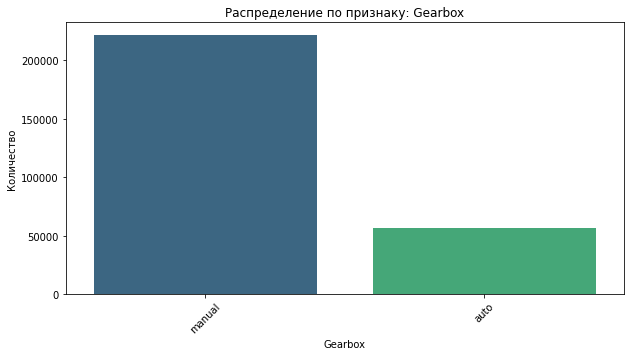

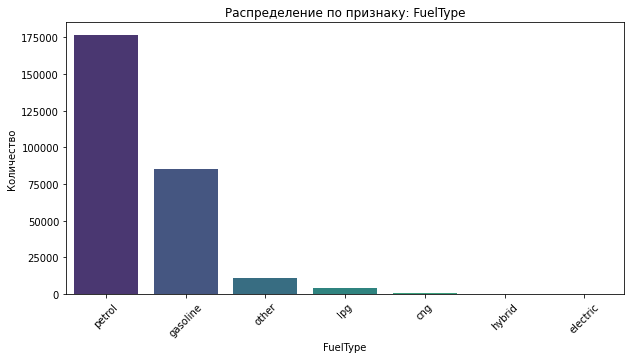

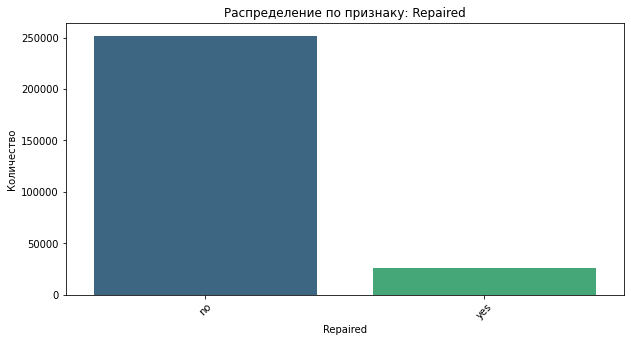

In [22]:
# Список категориальных признаков для анализа
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

# Построение графиков для категориальных признаков
plot_categorical_features(data, categorical_features)


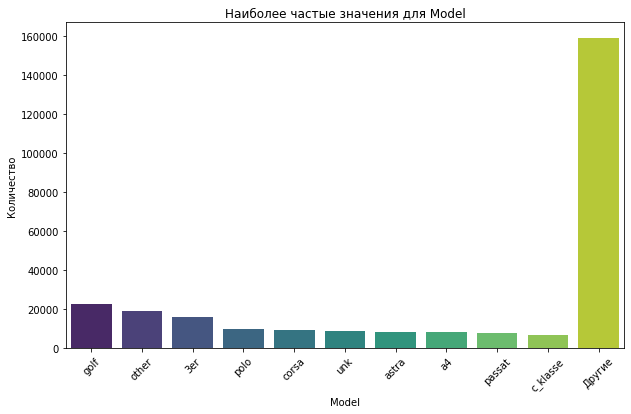

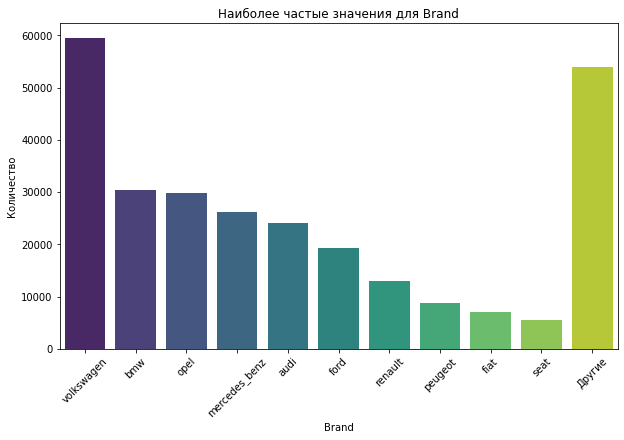

In [23]:
# Построение графиков для 'Model' и 'Brand'
plot_categorical_features_with_frequency(data, 'Model', top_n=10)
plot_categorical_features_with_frequency(data,'Brand', top_n=10)  # только 10 уникальных значения

In [24]:
analyze(data, 'autos.csv')


Анализ DataFrame: autos.csv

Общая информация:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unk,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07


<class 'pandas.core.frame.DataFrame'>
Int64Index: 277537 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        277537 non-null  object
 1   Price              277537 non-null  int64 
 2   VehicleType        277537 non-null  object
 3   RegistrationYear   277537 non-null  int64 
 4   Gearbox            277537 non-null  object
 5   Power              277537 non-null  int64 
 6   Model              277537 non-null  object
 7   Kilometer          277537 non-null  int64 
 8   RegistrationMonth  277537 non-null  int64 
 9   FuelType           277537 non-null  object
 10  Brand              277537 non-null  object
 11  Repaired           277537 non-null  object
 12  DateCreated        277537 non-null  object
 13  PostalCode         277537 non-null  int64 
 14  LastSeen           277537 non-null  object
dtypes: int64(6), object(9)
memory usage: 41.9+ MB


None

Описательная статистика:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
count,277537,277537.000000,277537,277537.000000,277537,277537.000000,277537,277537.000000,277537.000000,277537,277537,277537,277537,277537.000000,277537
unique,225166,NaN,9,NaN,2,NaN,250,NaN,NaN,7,40,2,105,NaN,146571
top,2016-03-31 18:50:16,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,2016-04-06 03:16:54
freq,5,NaN,79044,NaN,221289,NaN,22894,NaN,NaN,176372,59407,251805,10951,NaN,15
mean,NaN,5026.470770,NaN,2003.005632,NaN,121.451788,NaN,127897.757776,6.380922,NaN,NaN,NaN,NaN,51390.793433,NaN
std,NaN,4651.228187,NaN,6.375645,NaN,53.962849,NaN,36754.839785,3.347621,NaN,NaN,NaN,NaN,25750.017371,NaN
min,NaN,70.000000,NaN,1950.000000,NaN,20.000000,NaN,5000.000000,1.000000,NaN,NaN,NaN,NaN,1067.000000,NaN
25%,NaN,1450.000000,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,4.000000,NaN,NaN,NaN,NaN,31061.000000,NaN
50%,NaN,3400.000000,NaN,2003.000000,NaN,114.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,50674.000000,NaN
75%,NaN,7299.000000,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,72178.000000,NaN


------------------------------
Анализ столбца: DateCrawled
Тип данных: object, Количество уникальных значений: 225166
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: Price
Тип данных: int64, Количество уникальных значений: 3513
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество 0: 0, Процент 0: 0.0%
------------------------------ 

------------------------------
Анализ столбца: VehicleType
Тип данных: object, Количество уникальных значений: 9
Уникальные значения: ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'unk' 'wagon']
Количество пропущенных значений (NaN, None): 0, Процент: 0.0%
Количество пустых строк и пробелов: 0, Процент: 0.0%
------------------------------ 

------------------------------
Анализ столбца: RegistrationYear
Тип данных: int64, Количество уникальных значений: 67
Количество пропущенных 

In [25]:
# Преобразование столбцов с датами в формат datetime
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [26]:
data.dtypes

DateCrawled          datetime64[ns]
Price                         int64
VehicleType                  object
RegistrationYear              int64
Gearbox                      object
Power                         int64
Model                        object
Kilometer                     int64
RegistrationMonth             int64
FuelType                     object
Brand                        object
Repaired                     object
DateCreated          datetime64[ns]
PostalCode                    int64
LastSeen             datetime64[ns]
dtype: object

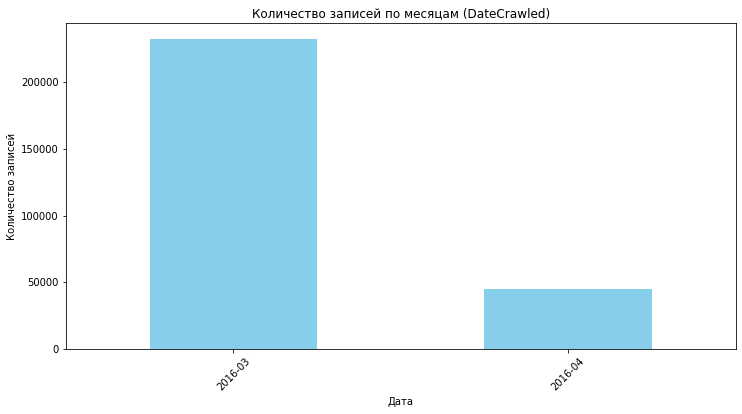

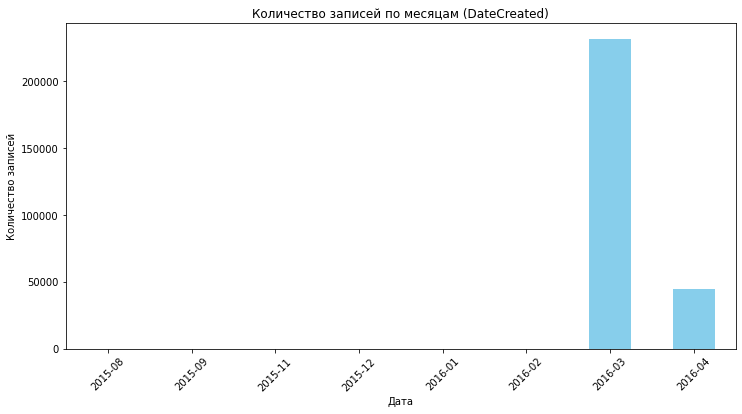

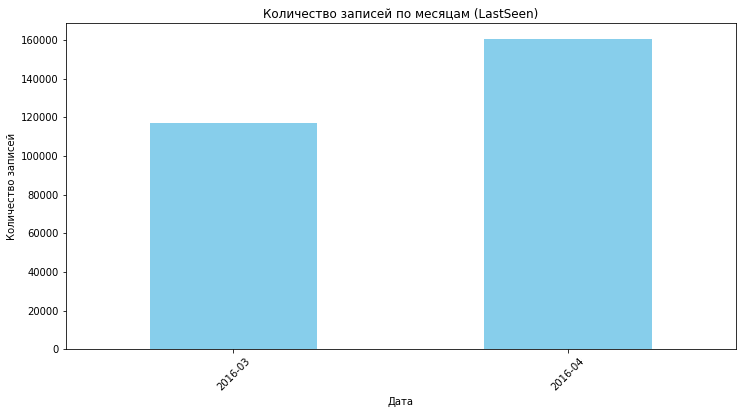

In [27]:
# Визуализация количества записей по месяцам для каждого из временных столбцов
plot_time_series(data, 'DateCrawled', 'Количество записей по месяцам (DateCrawled)')
plot_time_series(data, 'DateCreated', 'Количество записей по месяцам (DateCreated)')
plot_time_series(data, 'LastSeen', 'Количество записей по месяцам (LastSeen)')

In [28]:
report_removed_data(data)

Исходное количество записей: 354369
Количество записей после удаления: 277537
Количество удаленных записей: 76832
Доля удаленных данных: 21.68%


**Общая информация о данных**

Датасет содержит **277 538 записей** и **15 признаков** после удаления дубликатов и ненужных столбцов. Признаки включают как числовые, так и категориальные данные, а также временные метки.

## Пропуски и аномалии

В начальном датасете были пропуски в нескольких столбцах, таких как:
- **VehicleType**
- **Gearbox**
- **Model**
- **FuelType**
- **Repaired**

Эти пропуски были устранены заполнением заглушкой.

В столбце **Price** были удалены значения из границ [0;70], так как они не имеют смысла для предсказания рыночной стоимости автомобилей. 

В столбце **Power** были оставлены значения в границах (20;620). 

Год регистрации (**RegistrationYear**) был очищен от аномальных значений (например, 1000) и отфильтрован по разумным границам (1950 - 2016). 

В столбце **RegistrationMonth** были значения, равные 0, которые также были удалены.

**Преобразование данных**

Столбцы с датами (**DateCrawled**, **DateCreated**, **LastSeen**) были преобразованы в формат datetime, что позволит использовать их для дальнейшего анализа временных зависимостей или создания новых признаков (например, возраста автомобиля).


In [29]:
data\
    .corr()\
    .style\
    .background_gradient(cmap='coolwarm')

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
Price,1.000000,0.500260,0.509316,-0.395693,0.012815,0.063057
RegistrationYear,0.500260,1.000000,0.133872,-0.316407,0.005057,0.028368
Power,0.509316,0.133872,1.000000,0.107822,0.023271,0.053418
Kilometer,-0.395693,-0.316407,0.107822,1.000000,0.006127,-0.009762
RegistrationMonth,0.012815,0.005057,0.023271,0.006127,1.000000,-0.008691
PostalCode,0.063057,0.028368,0.053418,-0.009762,-0.008691,1.000000


In [30]:
# Удаление ненужных столбцов
columns_to_drop = ['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen']
data.drop(columns=columns_to_drop, inplace=True)
data.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,unk,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


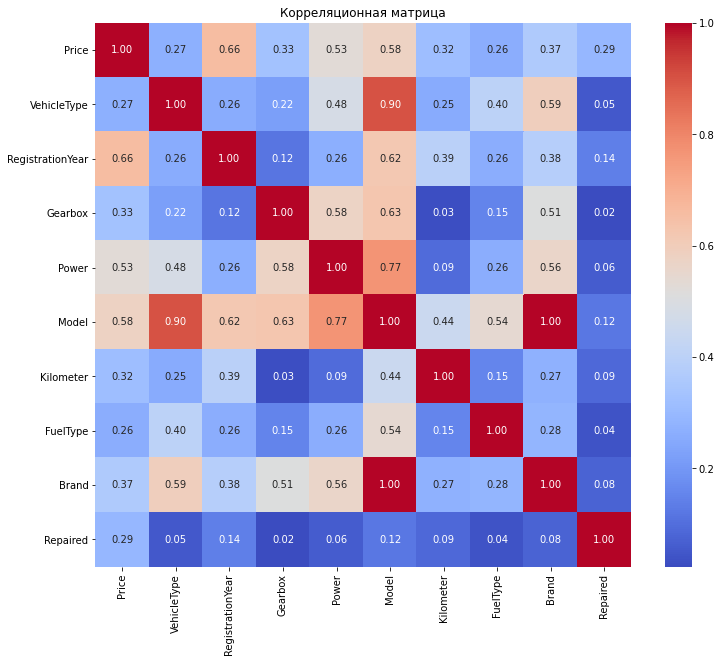

In [31]:
# Указываем явные интервальные столбцы
interval_cols = ['Price', 'Kilometer', 'Power', 'RegistrationYear']

# Вычисляем корреляционную матрицу
correlation_matrix = data.phik_matrix(interval_cols=interval_cols)

# Визуализируем корреляционную матрицу
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

**Учитывая высокую корреляцию между Model и Brand,  а также Model и VehicleType, то для предотвращения проблем с мультиколлинеарностью отавим только Model.**

In [32]:
# Удаление столбцов 'Brand' и 'VehicleType'
data = data.drop(columns=['Brand', 'VehicleType'])

data.head()

,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired
1,18300,2011,manual,190,unk,125000,gasoline,yes
2,9800,2004,auto,163,grand,125000,gasoline,no
3,1500,2001,manual,75,golf,150000,petrol,no
4,3600,2008,manual,69,fabia,90000,gasoline,no
5,650,1995,manual,102,3er,150000,petrol,yes


In [33]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 277537 entries, 1 to 354368
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             277537 non-null  int64 
 1   RegistrationYear  277537 non-null  int64 
 2   Gearbox           277537 non-null  object
 3   Power             277537 non-null  int64 
 4   Model             277537 non-null  object
 5   Kilometer         277537 non-null  int64 
 6   FuelType          277537 non-null  object
 7   Repaired          277537 non-null  object
dtypes: int64(4), object(4)
memory usage: 27.1+ MB


## Обучение моделей

In [34]:
# Создание копии датафрейма
data_copy = data.copy()


In [35]:
print(f"Количество дубликатов: {data_copy.duplicated().sum()}")

Количество дубликатов: 51042


In [36]:
data_copy = data_copy.drop_duplicates()
print(f"Количество дубликатов после обработки: {data_copy.duplicated().sum()}")

Количество дубликатов после обработки: 0


In [37]:
report_removed_data(data_copy)

Исходное количество записей: 354369
Количество записей после удаления: 226495
Количество удаленных записей: 127874
Доля удаленных данных: 36.08%


In [38]:
# Создание нового признака: возраст автомобиля
current_year = 2016
data_copy['CarAge'] = current_year - data_copy['RegistrationYear']
data_copy.head(5)

,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Repaired,CarAge
1,18300,2011,manual,190,unk,125000,gasoline,yes,5
2,9800,2004,auto,163,grand,125000,gasoline,no,12
3,1500,2001,manual,75,golf,150000,petrol,no,15
4,3600,2008,manual,69,fabia,90000,gasoline,no,8
5,650,1995,manual,102,3er,150000,petrol,yes,21


In [39]:
# Удаление столбца 'RegistrationYear' из DataFrame
data_copy = data_copy.drop(columns=['RegistrationYear'])

data_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226495 entries, 1 to 354368
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Price      226495 non-null  int64 
 1   Gearbox    226495 non-null  object
 2   Power      226495 non-null  int64 
 3   Model      226495 non-null  object
 4   Kilometer  226495 non-null  int64 
 5   FuelType   226495 non-null  object
 6   Repaired   226495 non-null  object
 7   CarAge     226495 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 15.6+ MB


In [40]:
# Преобразование категориальных признаков в числовой формат с помощью pd.get_dummies
data_copy = pd.get_dummies(data_copy, drop_first=True)

# Проверка результата
data_copy.head()

,Price,Power,Kilometer,CarAge,Gearbox_manual,Model_145,Model_147,Model_156,Model_159,Model_1_reihe,...,Model_ypsilon,Model_z_reihe,Model_zafira,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_yes
1,18300,190,125000,5,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,9800,163,125000,12,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1500,75,150000,15,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3600,69,90000,8,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5,650,102,150000,21,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [41]:
# Определяем целевой признак и признаки для обучения
target = data_copy['Price']
features = data_copy.drop(columns=['Price'])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

# Определяем числовые признаки 
numeric_features = ['Power', 'CarAge', 'Kilometer']

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_numeric = scaler.fit_transform(X_train[numeric_features])
X_test_numeric = scaler.transform(X_test[numeric_features])

# Удаляем числовые признаки из закодированных данных, так как они будут заменены масштабированными
X_train_final = np.hstack((X_train_numeric, X_train.drop(columns=numeric_features).values))
X_test_final = np.hstack((X_test_numeric, X_test.drop(columns=numeric_features).values))

# Проверка размерностей
print(f'Размерность обучающей выборки: {X_train_final.shape}, Размерность тестовой выборки: {X_test_final.shape}')

Размерность обучающей выборки: (169871, 260), Размерность тестовой выборки: (56624, 260)


In [42]:
def train_and_evaluate(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)  # Обучение модели
    training_time = time.time() - start_time
    
    # Предсказание на обучающей выборке
    predictions = model.predict(X_train)
    rmse = mean_squared_error(y_train, predictions, squared=False)  # Расчет RMSE
    
    return rmse, training_time  # Возвращаем RMSE и время обучения

In [43]:
# Модель 1: Линейная регрессия
linear_model = LinearRegression()
rmse_lr, training_time_lr = train_and_evaluate(linear_model, X_train, y_train)
print(f'Linear Regression - RMSE: {rmse_lr:.2f}, Время обучения: {training_time_lr:.2f} секунд')



Linear Regression - RMSE: 2762.84, Время обучения: 59.25 секунд


In [44]:
# Модель 2: CatBoost
catboost_model = CatBoostRegressor(
    learning_rate=0.4, 
    n_estimators=150,  
    random_seed=RANDOM_STATE,  
    verbose=0,  
    thread_count=-1  
)

# Оценка CatBoost
rmse_cat, training_time_cat = train_and_evaluate(catboost_model, X_train, y_train)
print(f'CatBoost - RMSE: {rmse_cat:.2f}, Время обучения: {training_time_cat:.2f} секунд')

CatBoost - RMSE: 1756.29, Время обучения: 4.85 секунд


In [45]:
# Модель 3: LightGBM 
model_lgb = lgb.LGBMRegressor(
    n_estimators=50,  
    learning_rate=0.4,  
    random_state=RANDOM_STATE,  
    n_jobs=-1  
)

# Оценка LightGBM
rmse_lgb, training_time_lgb = train_and_evaluate(model_lgb, X_train, y_train)
print(f'LightGBM - RMSE: {rmse_lgb:.2f}, Время обучения: {training_time_lgb:.2f} секунд')


LightGBM - RMSE: 1765.08, Время обучения: 382.22 секунд


## Анализ моделей

# Результаты моделей


- **Линейная регрессия**: RMSE = 2762.84, Время обучения = 59.25 секунд
- **CatBoost**: RMSE = 1756.29, Время обучения = 4.85 секунд
- **LightGBM**: RMSE = 1765.08, Время обучения = 382.22 секунд

**CatBoost** показал наилучшее качество предсказания (наименьшее значение RMSE) и самое быстрое время обучения. Таким образом, мы выберем **CatBoost** в качестве лучшей модели.



In [46]:
# Измерение времени предсказания на тестовой выборке
start_prediction_time = time.time()
test_predictions = catboost_model.predict(X_test)
prediction_time = time.time() - start_prediction_time

test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

print(f'CatBoost - RMSE на тестовой выборке: {test_rmse:.2f}')
print(f'Время предсказания на тестовой выборке: {prediction_time:.4f} секунд')

CatBoost - RMSE на тестовой выборке: 1777.31
Время предсказания на тестовой выборке: 0.1052 секунд


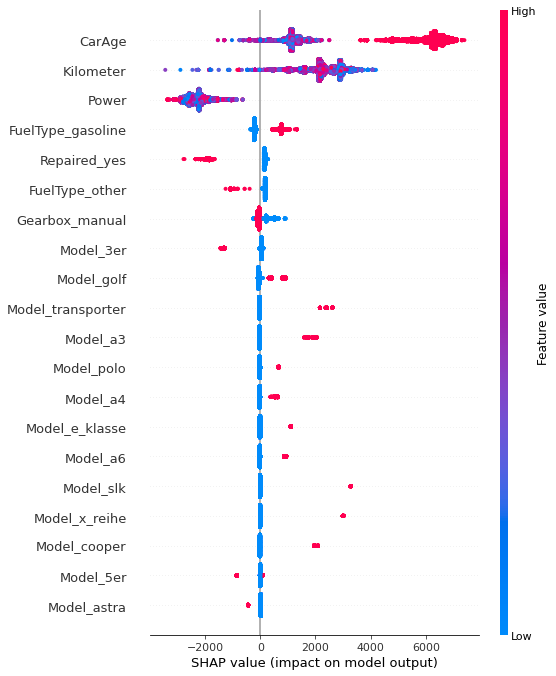

In [48]:
# Получаем важность признаков
explainer = shap.Explainer(catboost_model)
shap_values = explainer.shap_values(X_test_final)

# Визуализация важности признаков
shap.summary_plot(shap_values, X_test_final, feature_names=features.columns)


## Общий вывод

В ходе работы над проектом по разработке модели для определения рыночной стоимости автомобилей с пробегом были выполнены следующие шаги:

1. **Подготовка данных**: 
   - Датасет был очищен от дубликатов и ненужных столбцов.
   - Пропуски в данных были устранены путем удаления записей с отсутствующими значениями.
   - Кроме того, были удалены аномальные значения в столбцах, таких как `Price`, `Power` и `RegistrationYear`.

2. **Анализ данных**: 
   - Проведен детальный анализ признаков, выявлены корреляции между целевым признаком (ценой) и другими количественными признаками. Это помогло понять, какие факторы влияют на стоимость автомобилей.

3. **Обучение моделей**: 
   - Были протестированы три модели машинного обучения:
     - Линейная регрессия
     - LightGBM
     - CatBoost
   - Из всех моделей наилучшие результаты показала модель CatBoost: RMSE = 1756.29, Время обучения = 4.85 секунд. Линейная регрессия показала наихудшие результаты.

4. **Важность признаков**: 
   - Визуализирована важность признаков для модели **CatBoost**, что позволило выявить ключевые факторы, влияющие на предсказания. Наиболее значимые признаки включают тип автомобиля, тип топлива, пробег и модель автомобиля.


